In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, plot_precision_recall_curve, plot_roc_curve

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

import datetime as dt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
ready = pd.read_csv('ready.csv')
ready

,Unnamed: 0,lat,lon,day,month,Labels,hour_y
0,0,-6.270088,107.043609,25,9,True,10
1,1,-6.270088,107.043609,25,9,True,10
2,2,-6.270088,107.043609,25,9,True,10
3,3,-6.270088,107.043609,25,9,True,10
4,4,-6.270088,107.043609,25,9,True,10
...,...,...,...,...,...,...,...
3707443,3707443,-6.886813,107.581583,22,11,True,17
3707444,3707444,-6.886813,107.581583,22,11,True,17
3707445,3707445,-6.886813,107.581583,22,11,True,17
3707446,3707446,-6.886813,107.581583,22,11,True,17


In [3]:
ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707448 entries, 0 to 3707447
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   lat         float64
 2   lon         float64
 3   day         int64  
 4   month       int64  
 5   Labels      bool   
 6   hour_y      int64  
dtypes: bool(1), float64(2), int64(4)
memory usage: 173.2 MB


In [4]:
ready['x'] = np.cos(ready['lat']) * np.cos(ready['lon'])
ready['y'] = np.cos(ready['lat']) * np.sin(ready['lon'])
ready['z'] = np.sin(ready['lat'])

In [5]:
X = ready['x y z day month hour_y'.split()]
y = np.where(ready['Labels']==True,1,0)

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, random_state=24)

## LogisticRegression

In [7]:
lr_bal = LogisticRegression(class_weight='balanced', solver='liblinear')

In [8]:
skf = StratifiedKFold()
lr_bal_cv = cross_val_score(lr_bal, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


In [9]:
print('LogisticRegression score CV:', lr_bal_cv)
print('LogisticRegression score CV mean:', lr_bal_cv.mean())
print('LogisticRegression score CV std:', lr_bal_cv.std())

LogisticRegression score CV: [0.8676313  0.86796115 0.86777326 0.86776114 0.87026637]
LogisticRegression score CV mean: 0.8682786430024618
LogisticRegression score CV std: 0.0009994122019199175


## DecisionTreeClassifier

In [10]:
dtc = DecisionTreeClassifier()
dtc_cv = cross_val_score(dtc, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [11]:
print('DecisionTreeClassifier score CV:', dtc_cv)
print('DecisionTreeClassifier score CV mean:', dtc_cv.mean())
print('DecisionTreeClassifier score CV std:', dtc_cv.std())

DecisionTreeClassifier score CV: [1.         1.         0.99999907 1.         0.99999813]
DecisionTreeClassifier score CV mean: 0.9999994403571517
DecisionTreeClassifier score CV std: 7.461906095130516e-07


## Calibrated DTC

In [12]:
dtc = DecisionTreeClassifier()
dtc_cal = CalibratedClassifierCV(dtc, method='isotonic')
dtc_cal_cv = cross_val_score(dtc_cal, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished


In [13]:
print('DecisionTreeClassifier Calibrated score CV:', dtc_cal_cv)
print('DecisionTreeClassifier Calibrated score CV mean:', dtc_cal_cv.mean())
print('DecisionTreeClassifier Calibrated score CV std:', dtc_cal_cv.std())

DecisionTreeClassifier Calibrated score CV: [1.         1.         0.99999907 1.         0.99999813]
DecisionTreeClassifier Calibrated score CV mean: 0.9999994403571517
DecisionTreeClassifier Calibrated score CV std: 7.461906095130516e-07


## LogisticRegression Polynomial

In [36]:
transformer = ColumnTransformer([
        ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
], remainder='passthrough')

logit_pipe = Pipeline([
    ('trans', transformer),
    ('clf', LogisticRegression(random_state=2020))
])

In [37]:
logit_pipe_cv = cross_val_score(logit_pipe, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')
print('Logit Poly score CV:', logit_pipe_cv)
print('Logit Poly score CV mean:', logit_pipe_cv.mean())
print('Logit Poly score CV std:', logit_pipe_cv.std())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logit Poly score CV: [0.98137185 0.98135503 0.98136529 0.98135782 0.98137555]
Logit Poly score CV mean: 0.9813651079809835
Logit Poly score CV std: 7.864487806645093e-06


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


## KNeighborsClassifier
(Too heavy for my laptop)

In [16]:
# X.head()

,x,y,z,day,month,hour_y
0,0.973706,0.227431,0.013097,25,9,10
1,0.973706,0.227431,0.013097,25,9,10
2,0.973706,0.227431,0.013097,25,9,10
3,0.973706,0.227431,0.013097,25,9,10
4,0.973706,0.227431,0.013097,25,9,10


In [17]:
# knn = KNeighborsClassifier()

# scaler = ColumnTransformer([
#         ('scaler', StandardScaler(), ['x','y','z', 'day', 'month'])
# ])

# knn_pipe = Pipeline([
#     ('trans', transformer),
#     ('clf', knn)
# ])
# knn_cv = cross_val_score(knn_pipe, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

In [18]:
# print('KNN score CV:', knn_cv)
# print('KNN score CV mean:', knn_cv.mean())
# print('KNN score CV std:', knn_cv.std())

## Gaussian NaiveBayes

In [19]:
from scipy import stats

In [20]:
ready.isna().sum()/len(ready)*100

Unnamed: 0    0.0
lat           0.0
lon           0.0
day           0.0
month         0.0
Labels        0.0
hour_y        0.0
x             0.0
y             0.0
z             0.0
dtype: float64

In [21]:
for i in 'x y z'.split():
    s, p = stats.normaltest(ready[i])
    if p < 0.05:
        print(f'{i} not normal')
    else:
        print(f'{i} normal')

x not normal
y not normal
z not normal


In [22]:
gnb = GaussianNB()

gnb_cv = cross_val_score(gnb, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


In [23]:
print('GNB score CV:', gnb_cv)
print('GNB score CV mean:', gnb_cv.mean())
print('GNB score CV std:', gnb_cv.std())

GNB score CV: [0.96090306 0.96099958 0.96090266 0.96091319 0.96088928]
GNB score CV mean: 0.960921552077344
GNB score CV std: 3.974571354652081e-05


## Comparing All Model

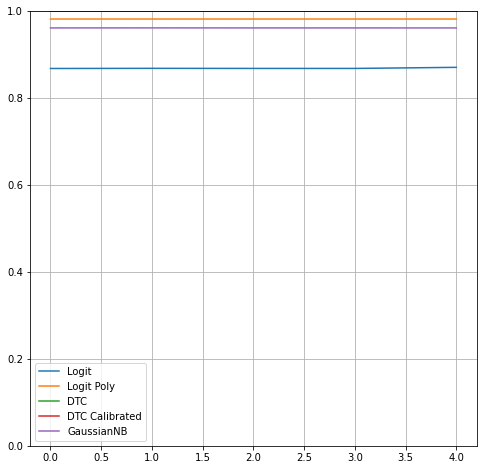

In [38]:
plt.figure(figsize=(8,8))
plt.plot(range(len(lr_bal_cv)), lr_bal_cv, label='Logit')
plt.plot(range(len(logit_pipe_cv)), logit_pipe_cv, label='Logit Poly')
plt.plot(range(len(dtc_cv)), dtc_cv, label='DTC')
plt.plot(range(len(dtc_cal_cv)), dtc_cal_cv, label='DTC Calibrated')
plt.plot(range(len(gnb_cv)), gnb_cv, label='GaussianNB')
plt.legend()
plt.ylim(0,1)
plt.grid()
plt.show()

In [25]:
print(dtc_cv.mean())
print(dtc_cal_cv.mean())

0.9999994403571517
0.9999994403571517


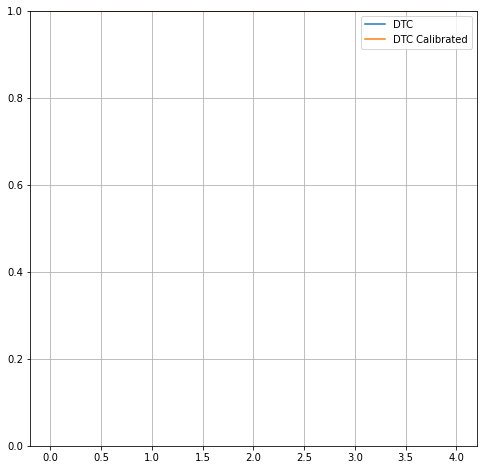

In [26]:
plt.figure(figsize=(8,8))
plt.plot(range(len(dtc_cv)), dtc_cv, label='DTC')
plt.plot(range(len(dtc_cal_cv)), dtc_cal_cv, label='DTC Calibrated')
plt.legend()
plt.ylim(0,1)
plt.grid()
plt.show()

In [27]:
dtc_cal.fit(X_train_val, y_train_val)
y_pred_dtc_cal = dtc_cal.predict(X_test)

In [28]:
print(classification_report(y_test, y_pred_dtc_cal))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33436
           1       1.00      1.00      1.00    893426

    accuracy                           1.00    926862
   macro avg       1.00      1.00      1.00    926862
weighted avg       1.00      1.00      1.00    926862



## Using Voting Classifier

In [39]:
vclf = VotingClassifier([('logit',logit_pipe), ('dtc', dtc_cal), ('gaussian', gnb)], voting='soft', n_jobs=-1)
# vclf.fit(X_train_val, y_train_val)
vclf_cv = cross_val_score(vclf, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.3min finished


In [40]:
print('VCLF score CV:', vclf_cv)
print('VCLF score CV mean:', vclf_cv.mean())
print('VCLF score CV std:', vclf_cv.std())

VCLF score CV: [0.99195325 0.9918156  0.99189451 0.99186607 0.99176329]
VCLF score CV mean: 0.9918585444163168
VCLF score CV std: 6.517262941469088e-05


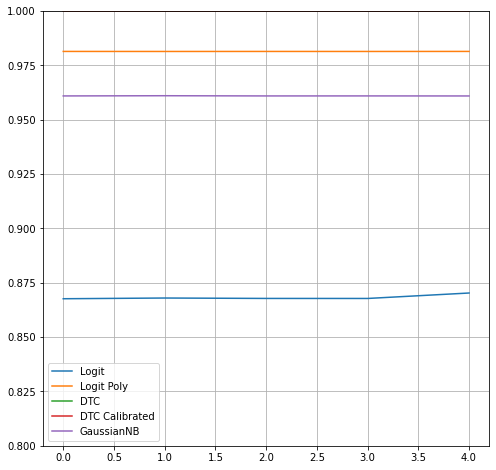

In [41]:
plt.figure(figsize=(8,8))
plt.plot(range(len(lr_bal_cv)), lr_bal_cv, label='Logit')
plt.plot(range(len(logit_pipe_cv)), logit_pipe_cv, label='Logit Poly')
plt.plot(range(len(dtc_cv)), dtc_cv, label='DTC')
plt.plot(range(len(dtc_cal_cv)), dtc_cal_cv, label='DTC Calibrated')
plt.plot(range(len(gnb_cv)), gnb_cv, label='GaussianNB')
plt.plot(range(len(vclf_cv)), vclf_cv, label='VotingSoft')
plt.legend()
plt.ylim(0.8,1)
plt.grid()
plt.show()

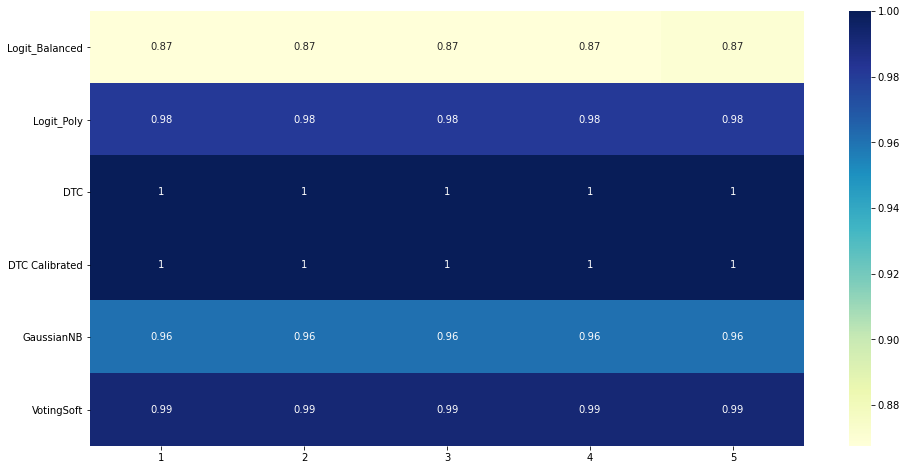

In [42]:
all_metrics = pd.DataFrame([lr_bal_cv, logit_pipe_cv, dtc_cv, dtc_cal_cv, gnb_cv, vclf_cv],
                           columns=[1,2,3,4,5],
                          index=['Logit_Balanced', 'Logit_Poly', 'DTC', 'DTC Calibrated', 'GaussianNB', 'VotingSoft'])
plt.figure(figsize=(16,8))
sns.heatmap(all_metrics, annot=True, cmap='YlGnBu')
plt.show()

## DTC with KBins (`hour` and `day`)

In [33]:
X_train_val.head()

,x,y,z,day,month,hour_y
2822620,0.556439,0.549660,-0.623097,2,10,18
152859,0.562794,0.572634,-0.596115,30,10,10
1045314,0.945069,-0.000697,-0.326870,30,10,16
2338709,0.991760,0.087273,-0.093783,26,10,15
2743121,0.991941,-0.044647,-0.118576,30,10,13


In [49]:
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

kbins_trans = ColumnTransformer([
    ('kbins', kbins, ['day','hour_y'])
], remainder='passthrough')

dtc_bins = Pipeline([
    ('kbins', kbins_trans),
    ('dtc', dtc)
])

In [50]:
dtc_bins_cv = cross_val_score(dtc_bins, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.7s finished


In [51]:
print('DTC Bins score CV:', dtc_bins_cv)
print('DTC Bins score CV mean:', dtc_bins_cv.mean())
print('DTC Bins score CV std:', dtc_bins_cv.std())

DTC Bins score CV: [0.99362863 0.99357606 0.99367902 0.99351731 0.99358736]
DTC Bins score CV mean: 0.9935976768612008
DTC Bins score CV std: 5.404943051305842e-05


## Logit Poly and Binning

In [54]:
transformer = ColumnTransformer([
        ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z']),
        ('kbins', kbins, ['day','hour_y'])
], remainder='passthrough')

logit_pipe_new = Pipeline([
    ('trans', transformer),
    ('clf', LogisticRegression(random_state=2020))
])

In [56]:
logit_pipe_new_cv = cross_val_score(logit_pipe_new, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [57]:
print('Logit Poly Bins score CV:', logit_pipe_new_cv)
print('Logit Poly Bins score CV mean:', logit_pipe_new_cv.mean())
print('Logit Poly Bins score CV std:', logit_pipe_new_cv.std())

Logit Poly Bins score CV: [0.98148565 0.98149122 0.98153598 0.98147816 0.98150894]
Logit Poly Bins score CV mean: 0.9814999888719995
Logit Poly Bins score CV std: 2.0662302929762793e-05


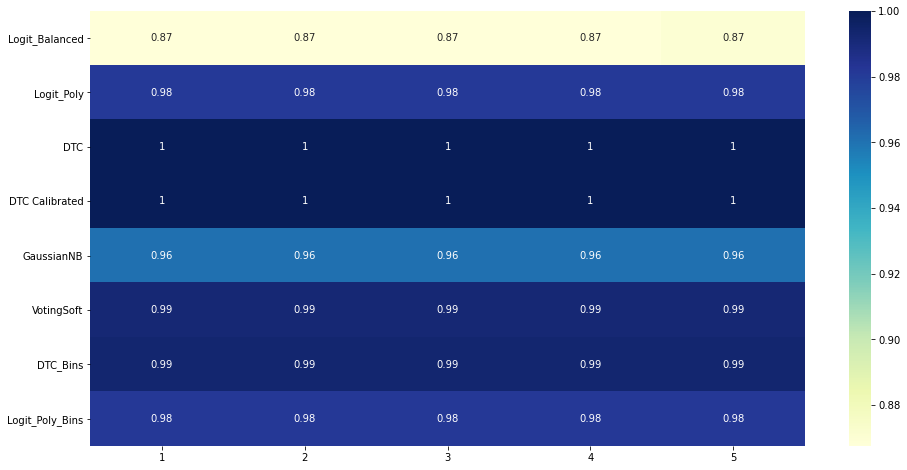

In [59]:
all_metrics = pd.DataFrame([lr_bal_cv, logit_pipe_cv, dtc_cv, dtc_cal_cv, gnb_cv, vclf_cv, dtc_bins_cv, logit_pipe_new_cv],
                           columns=[1,2,3,4,5],
                          index=['Logit_Balanced', 'Logit_Poly', 'DTC', 'DTC Calibrated', 'GaussianNB', 'VotingSoft', 'DTC_Bins', 'Logit_Poly_Bins'])
plt.figure(figsize=(16,8))
sns.heatmap(all_metrics, annot=True, cmap='YlGnBu')
plt.show()

C:\Users\R7891\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


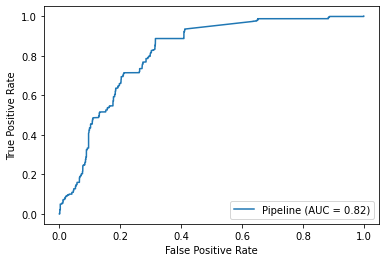

In [95]:
logit_pipe_new.fit(X_train_val, y_train_val)
plot_roc_curve(logit_pipe_new, X_test, y_test)

In [99]:
from sklearn.metrics import roc_curve
fpr, tpr, t = roc_curve(y_test, logit_pipe_new.predict_proba(X_test)[:,1])

roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'threshold': t})
roc_df[roc_df['tpr']>= 0.9].sort_values('fpr').head()

,fpr,tpr,threshold
2368,0.40896,0.902663,0.911703
2388,0.40896,0.907497,0.903398
2389,0.40896,0.907891,0.902913
2390,0.40896,0.908011,0.902819
2391,0.40896,0.908180,0.902727


In [92]:
y_pred = logit_pipe_new.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     33436
           1       0.96      1.00      0.98    893426

    accuracy                           0.96    926862
   macro avg       0.48      0.50      0.49    926862
weighted avg       0.93      0.96      0.95    926862



In [100]:
new_thr = 0.887758
y_pred088 = np.where(logit_pipe_new.predict_proba(X_test)[:,1]>new_thr, 1, 0)
print(classification_report(y_test, y_pred088))

              precision    recall  f1-score   support

           0       0.22      0.59      0.32     33436
           1       0.98      0.92      0.95    893426

    accuracy                           0.91    926862
   macro avg       0.60      0.76      0.63    926862
weighted avg       0.96      0.91      0.93    926862



In [53]:
test = pd.read_csv('data_test.csv')

In [60]:
test.head()

,Ids
0,2e6992a84_2020-11-25_18
1,2e68e62f4_2020-11-29_20
2,2e68e81a4_2020-11-27_10
3,2e69eec04_2020-11-24_7
4,2e698e4a4_2020-11-27_8


In [68]:
test['Ids'].str.split('_')

0        [2e6992a84, 2020-11-25, 18]
1        [2e68e62f4, 2020-11-29, 20]
2        [2e68e81a4, 2020-11-27, 10]
3         [2e69eec04, 2020-11-24, 7]
4         [2e698e4a4, 2020-11-27, 8]
                    ...             
13836     [2e68dd414, 2020-11-26, 5]
13837    [2e698541c, 2020-11-24, 22]
13838    [2e69e8e0c, 2020-11-24, 10]
13839    [2e699a1cc, 2020-11-24, 18]
13840    [2e698d804, 2020-11-25, 19]
Name: Ids, Length: 13841, dtype: object

In [71]:
import s2cell

In [84]:
def ids_to_df(df):
    test_df2 = pd.DataFrame()
    test_df2['s2cell_token'] = df['Ids'].str.split('_').apply(lambda x: x[0])
    test_df2['date'] = df['Ids'].str.split('_').apply(lambda x: x[1])
    test_df2['date'] = test_df2['date'].str.split('-')
    test_df2['hour'] = df['Ids'].str.split('_').apply(lambda x: x[2])
    
    test_df2['year'] = test_df2['date'].apply(lambda x: int(x[0]))
    test_df2['month'] = test_df2['date'].apply(lambda x: int(x[1]))
    test_df2['day'] = test_df2['date'].apply(lambda x: int(x[2]))
    test_df2['hour'] = test_df2['hour'].astype('int')
    
    test_df2['lat'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[0])
    test_df2['lon'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[1])
    
    test_df2['x'] = np.cos(test_df2['lat']) * np.cos(test_df2['lon'])
    test_df2['y'] = np.cos(test_df2['lat']) * np.sin(test_df2['lon'])
    test_df2['z'] = np.sin(test_df2['lat'])
    
    test_df2 = test_df2[['x', 'y', 'z', 'day', 'month', 'hour']]
    
    return test_df2

In [85]:
X_train_val.head(2)

,x,y,z,day,month,hour_y
2822620,0.556439,0.549660,-0.623097,2,10,18
152859,0.562794,0.572634,-0.596115,30,10,10


In [104]:
X.head()

,x,y,z,day,month,hour_y
0,0.973706,0.227431,0.013097,25,9,10
1,0.973706,0.227431,0.013097,25,9,10
2,0.973706,0.227431,0.013097,25,9,10
3,0.973706,0.227431,0.013097,25,9,10
4,0.973706,0.227431,0.013097,25,9,10


In [101]:
logit_pipe_new.fit(X,y)

C:\Users\R7891\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['x', 'y', 'z']),
                                                 ('kbins',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['day', 'hour_y'])])),
                ('clf', LogisticRegression(random_state=2020))])

In [106]:
new_test = ids_to_df(test)
new_test.rename(columns={'hour': 'hour_y'}, inplace=True)
new_test.head()

,x,y,z,day,month,hour_y
0,0.994031,0.108207,-0.013921,25,11,18
1,0.561143,0.574345,-0.596025,29,11,20
2,0.525794,0.591784,-0.611009,27,11,10
3,0.996602,-0.021315,-0.079557,24,11,7
4,0.972344,0.233176,0.013294,27,11,8


In [109]:
final_pred = np.where(logit_pipe_new.predict_proba(new_test)[:,1]>new_thr, True, False)

In [110]:
test['Labels'] = final_pred
test.head()

,Ids,Labels
0,2e6992a84_2020-11-25_18,True
1,2e68e62f4_2020-11-29_20,True
2,2e68e81a4_2020-11-27_10,False
3,2e69eec04_2020-11-24_7,False
4,2e698e4a4_2020-11-27_8,True


In [112]:
test.to_csv('submit.csv', index=False)

## IMPROVING!